# Imports

In [1]:
import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle
import pickle
import h5py
import json
import matplotlib.pyplot as plt 

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
from nltk import word_tokenize

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.models import model_from_json


# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook



/home/sunbeam/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
Using TensorFlow backend.


In [2]:
# data=pd.read_csv('/home/sunbeam/Downloads/text_emotion.csv', encoding='latin-1')

In [3]:
data

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


# Loading Data

In [2]:
def ingest():
    data = pd.read_csv('/home/sunbeam/Aniket_NLP/trainingandtestdata/trainingandtestdata/tweets.csv', encoding='latin-1') # Enter your file location
    data.columns=["Sentiment","ItemID","Date","Blank","SentimentSource","SentimentText"]
    data.drop(['ItemID', 'SentimentSource'], axis=1, inplace=True)
    data = data[data.Sentiment.isnull() == False]
    data['Sentiment'] = data['Sentiment'].map( {4:1, 0:0}) #Converting 4 to 1
    data = data[data['SentimentText'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    print ('dataset loaded with shape', data.shape  )  
    return data

data = ingest()

dataset loaded with shape (1599999, 4)


In [3]:
data

,Sentiment,Date,Blank,SentimentText
0,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,is upset that he can't update his Facebook by ...
1,0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,@Kenichan I dived many times for the ball. Man...
2,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,my whole body feels itchy and like its on fire
3,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,"@nationwideclass no, it's not behaving at all...."
4,0,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,@Kwesidei not the whole crew
...,...,...,...,...
1599994,1,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,Just woke up. Having no school is the best fee...
1599995,1,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDB.com - Very cool to hear old Walt interv...
1599996,1,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,Are you ready for your MoJo Makeover? Ask me f...
1599997,1,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,Happy 38th Birthday to my boo of alll time!!! ...


# Processing Data

In [4]:
tokenizer = TweetTokenizer()
def tokenize(tweet):
    try:
        tweet = tweet.lower()
        tokens = tokenizer.tokenize(tweet)
        tokens = list(filter(lambda t: not t.startswith('@'), tokens))
        tokens = list(filter(lambda t: not t.startswith('#'), tokens))
        tokens = list(filter(lambda t: not t.startswith('http'), tokens))
        return tokens
    except:
        return 'NC'

In [5]:
def postprocess(data):
#     , n=1000000
#     data = data.head(n)
    data['tokens'] = data['SentimentText'].progress_map(tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

data = postprocess(data)

progress-bar: 100%|██████████| 1599999/1599999 [01:22<00:00, 19287.69it/s]


# Labelise Data

In [6]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below

def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

In [7]:
#Splitting for training and testing
x_train, x_test, y_train, y_test = train_test_split(np.array(data.head(1000000).tokens),
                                                    np.array(data.head(1000000).Sentiment), test_size=0.2)


In [8]:
x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST') 

0it [00:00, ?it/s]/home/sunbeam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
800000it [00:04, 168953.64it/s]
200000it [00:00, 313816.19it/s]


In [9]:
data_labellised= labelizeTweets(np.array(data.tokens), 'data')

0it [00:00, ?it/s]/home/sunbeam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
1599999it [00:07, 215831.89it/s]


# Builidng word2vec vocabulary and training

In [10]:
n=1000000
n_dim = 200
tweet_w2v = Word2Vec(size=n_dim, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(data_labellised)])

100%|██████████| 1599999/1599999 [00:00<00:00, 3780748.89it/s]


In [11]:
tweet_w2v.train([x.words for x in tqdm(data_labellised)],total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.iter) 

100%|██████████| 1599999/1599999 [00:00<00:00, 3568027.77it/s]
/home/sunbeam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(85543136, 117647830)

In [11]:
#Save the w2v model
#tweet_w2v.save('w2vmodel')
#Load the w2v model
#new_w2vmodel = gensim.models.Word2Vec.load('w2vmodel')

In [26]:
#convert any word(present in vocabulary) to vector.
tweet_w2v['hello']

/home/sunbeam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([ 0.20836912,  2.5485075 , -0.05430328,  1.0849878 ,  1.7388756 ,
        0.3029194 ,  1.9079814 ,  0.5964185 ,  1.7996144 ,  0.7365948 ,
       -1.0590601 , -1.6074849 , -0.3130897 , -0.450676  , -1.5491396 ,
       -1.9328395 ,  1.5902896 , -0.2294576 , -1.8746078 , -0.00317719,
        1.6110058 , -0.175764  ,  0.5504836 , -0.7253448 , -1.1655475 ,
        1.2104034 , -0.02840703, -1.3577045 , -0.6547083 ,  0.40389255,
       -0.84765315, -1.1433196 ,  2.6146529 ,  1.133139  ,  1.0815672 ,
        0.6103417 , -1.2573897 ,  0.34735167,  1.1150357 ,  0.13489436,
        0.05966085, -1.2049497 , -0.17108816,  0.29391626,  0.5617971 ,
        0.18308474, -1.159767  , -0.59694666,  1.7754737 , -0.60108584,
       -0.33991838, -0.19424702,  0.20819932,  0.53675634, -0.25872684,
       -1.480825  ,  1.014044  ,  0.86979574, -0.5195797 , -0.5845154 ,
        0.3615006 ,  0.91523993, -0.8547796 ,  1.8090047 , -0.2303612 ,
       -1.9262967 ,  0.12752348, -1.2905177 , -1.8632517 ,  1.43

In [42]:
#Find similar words
tweet_w2v.most_similar('color')

/home/sunbeam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('colour', 0.8804690837860107),
 ('purple', 0.6794283986091614),
 ('colors', 0.6769846677780151),
 ('pink', 0.6575045585632324),
 ('polish', 0.6169794797897339),
 ('colours', 0.6064357161521912),
 ('yellow', 0.6044750213623047),
 ('silver', 0.5987120866775513),
 ('shade', 0.598527729511261),
 ('colored', 0.5906295776367188)]

# Plotting the vectors

In [12]:
# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
                        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                        x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [tweet_w2v[w] for w in list(tweet_w2v.wv.vocab.keys())[:5000]]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(tweet_w2v.wv.vocab.keys())[:5000]

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

/home/sunbeam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.050s...
[t-SNE] Computed neighbors for 5000 samples in 10.231s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.698543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.657906
[t-SNE] KL divergence after 1000 iterations: 2.289702


# TF-IDF matrix of data

In [15]:
print ('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in data_labellised])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 35103


In [16]:
#Save the tfidf 
# with open("tfidfdict.txt", "wb") as myFile:
#     pickle.dump(tfidf, myFile)
# with open("tfidfdict.txt", "rb") as myFile:
#     tfidf = pickle.load(myFile)


# Build tweet vector to give input to FFNN

In [13]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word] #combining w2v vectors with tfidf value of words in the tweet.
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [16]:
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)


0it [00:00, ?it/s]/home/sunbeam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  

506it [00:00, 5056.59it/s]
1117it [00:00, 5330.17it/s]
1782it [00:00, 5665.38it/s]
2419it [00:00, 5859.06it/s]
3085it [00:00, 6077.26it/s]
3689it [00:00, 6063.43it/s]
4288it [00:00, 6041.07it/s]
4871it [00:00, 5974.82it/s]
5560it [00:00, 6221.05it/s]
6249it [00:01, 6406.62it/s]
6913it [00:01, 6473.62it/s]
7572it [00:01, 6507.03it/s]
8219it [00:01, 6381.65it/s]
8876it [00:01, 6436.94it/s]
9567it [00:01, 6570.35it/s]
10259it [00:01, 6668.88it/s]
10926it [00:01, 6645.27it/s]
11597it [00:01, 6664.45it/s]
12264it [00:01, 6523.10it/s]
12917it [00:02, 6503.07it/s]
13569it [00:02, 6507.98it/s]
14221it [00:02, 6322.33it/s]
14855it [00:02, 6073.61it/s]
15474it [00:02, 6105.57it/s]
16087it [00:02, 5827.24it/s]
16674it [00:02, 5770.11it/s]
17316it [00:02, 5950.37it/s]
17915it [0

149401it [00:26, 5877.76it/s]
150056it [00:26, 6059.46it/s]
150714it [00:26, 6203.23it/s]
151362it [00:26, 6279.13it/s]
152009it [00:26, 6334.55it/s]
152650it [00:26, 6272.82it/s]
153283it [00:26, 6265.41it/s]
153924it [00:26, 6305.21it/s]
154584it [00:27, 6390.81it/s]
155237it [00:27, 6427.74it/s]
155921it [00:27, 6543.53it/s]
156581it [00:27, 6558.98it/s]
157239it [00:27, 6532.76it/s]
157894it [00:27, 6507.69it/s]
158552it [00:27, 6528.99it/s]
159206it [00:27, 6520.18it/s]
159859it [00:27, 6520.04it/s]
160520it [00:27, 6545.22it/s]
161197it [00:28, 6608.85it/s]
161873it [00:28, 6649.50it/s]
162539it [00:28, 6587.73it/s]
163208it [00:28, 6612.71it/s]
163896it [00:28, 6689.20it/s]
164566it [00:28, 6679.80it/s]
165236it [00:28, 6683.08it/s]
165906it [00:28, 6687.29it/s]
166575it [00:28, 6650.11it/s]
167267it [00:28, 6726.28it/s]
167940it [00:29, 6713.53it/s]
168628it [00:29, 6760.63it/s]
169305it [00:29, 6722.61it/s]
169978it [00:29, 6709.72it/s]
170653it [00:29, 6720.62it/s]
171326it [

297036it [00:52, 6492.36it/s]
297691it [00:53, 6316.05it/s]
298328it [00:53, 6301.87it/s]
298985it [00:53, 6376.22it/s]
299675it [00:53, 6523.68it/s]
300330it [00:53, 6457.06it/s]
300993it [00:53, 6506.46it/s]
301646it [00:53, 5928.52it/s]
302306it [00:53, 6113.78it/s]
302956it [00:53, 6223.04it/s]
303586it [00:54, 6232.96it/s]
304254it [00:54, 6356.80it/s]
304906it [00:54, 6403.35it/s]
305550it [00:54, 5124.98it/s]
306106it [00:54, 4258.42it/s]
306587it [00:54, 3797.59it/s]
307015it [00:54, 3563.76it/s]
307408it [00:55, 3227.07it/s]
307763it [00:55, 3141.67it/s]
308100it [00:55, 2966.22it/s]
308415it [00:55, 2945.96it/s]
308723it [00:55, 2859.91it/s]
309019it [00:55, 2878.63it/s]
309314it [00:55, 2831.85it/s]
309602it [00:55, 2815.94it/s]
310015it [00:55, 3112.59it/s]
310518it [00:56, 3514.17it/s]
311066it [00:56, 3937.66it/s]
311698it [00:56, 4439.57it/s]
312188it [00:56, 3832.83it/s]
312775it [00:56, 4276.79it/s]
313420it [00:56, 4754.26it/s]
314042it [00:56, 5114.61it/s]
314698it [

445545it [01:21, 1465.93it/s]
445754it [01:22, 978.48it/s] 
445917it [01:22, 764.31it/s]
446046it [01:22, 664.31it/s]
446152it [01:23, 665.85it/s]
446307it [01:23, 801.61it/s]
446419it [01:23, 702.02it/s]
446633it [01:23, 879.24it/s]
446894it [01:23, 1097.51it/s]
447119it [01:23, 1105.74it/s]
447272it [01:24, 829.57it/s] 
447395it [01:24, 601.24it/s]
447492it [01:24, 433.70it/s]
447568it [01:24, 393.70it/s]
447631it [01:25, 343.58it/s]
447683it [01:25, 331.28it/s]
447769it [01:25, 388.17it/s]
447821it [01:25, 316.60it/s]
447881it [01:25, 364.48it/s]
447928it [01:25, 390.12it/s]
447975it [01:26, 270.13it/s]
448013it [01:26, 270.65it/s]
448048it [01:26, 258.52it/s]
448091it [01:26, 218.26it/s]
448164it [01:26, 276.09it/s]
448205it [01:27, 150.90it/s]
448236it [01:27, 163.49it/s]
448264it [01:28, 73.90it/s] 
448300it [01:28, 92.55it/s]
448321it [01:29, 71.29it/s]
448337it [01:29, 57.60it/s]
448351it [01:29, 67.17it/s]
448363it [01:29, 56.21it/s]
448373it [01:30, 50.66it/s]
448381it [01:30

459721it [02:04, 314.55it/s]
459770it [02:04, 348.70it/s]
459822it [02:04, 382.36it/s]
459875it [02:04, 408.79it/s]
459921it [02:04, 388.16it/s]
459964it [02:05, 323.90it/s]
460001it [02:05, 262.20it/s]
460033it [02:05, 191.93it/s]
460059it [02:05, 140.93it/s]
460080it [02:06, 138.93it/s]
460099it [02:06, 95.65it/s] 
460114it [02:06, 106.82it/s]
460129it [02:06, 113.31it/s]
460144it [02:06, 120.54it/s]
460159it [02:06, 92.16it/s] 
460175it [02:07, 105.40it/s]
460194it [02:07, 120.08it/s]
460209it [02:07, 125.80it/s]
460224it [02:07, 121.92it/s]
460238it [02:07, 84.91it/s] 
460249it [02:07, 75.75it/s]
460259it [02:08, 46.33it/s]
460284it [02:08, 61.05it/s]
460301it [02:08, 75.31it/s]
460340it [02:08, 98.50it/s]
460360it [02:08, 85.08it/s]
460376it [02:09, 62.87it/s]
460404it [02:09, 78.85it/s]
460429it [02:09, 99.13it/s]
460447it [02:09, 102.93it/s]
460472it [02:09, 123.97it/s]
460514it [02:09, 156.22it/s]
460539it [02:10, 158.98it/s]
460573it [02:10, 133.03it/s]
460592it [02:10, 76.13i

468313it [02:42, 365.01it/s]
468363it [02:42, 388.51it/s]
468418it [02:42, 418.54it/s]
468462it [02:42, 409.90it/s]
468505it [02:42, 393.86it/s]
468546it [02:42, 396.17it/s]
468593it [02:42, 414.91it/s]
468644it [02:43, 439.21it/s]
468689it [02:43, 397.88it/s]
468731it [02:43, 375.76it/s]
468770it [02:43, 355.69it/s]
468807it [02:43, 350.14it/s]
468854it [02:43, 376.30it/s]
468893it [02:43, 374.90it/s]
468941it [02:43, 400.72it/s]
468994it [02:44, 419.92it/s]
469039it [02:44, 428.49it/s]
469083it [02:44, 349.26it/s]
469121it [02:44, 336.33it/s]
469157it [02:44, 330.66it/s]
469208it [02:44, 369.36it/s]
469248it [02:44, 353.48it/s]
469286it [02:44, 319.98it/s]
469332it [02:44, 350.95it/s]
469373it [02:45, 366.69it/s]
469412it [02:45, 292.13it/s]
469447it [02:45, 300.06it/s]
469488it [02:45, 311.93it/s]
469528it [02:45, 326.06it/s]
469563it [02:45, 310.13it/s]
469596it [02:45, 304.88it/s]
469639it [02:45, 328.20it/s]
469674it [02:46, 333.59it/s]
469713it [02:46, 348.21it/s]
469759it [02:4

479372it [03:13, 349.73it/s]
479420it [03:13, 373.66it/s]
479459it [03:13, 376.45it/s]
479505it [03:13, 396.60it/s]
479546it [03:13, 367.73it/s]
479584it [03:13, 338.62it/s]
479620it [03:13, 330.02it/s]
479658it [03:13, 342.68it/s]
479700it [03:14, 361.27it/s]
479737it [03:14, 340.95it/s]
479778it [03:14, 352.36it/s]
479824it [03:14, 376.96it/s]
479863it [03:14, 325.71it/s]
479898it [03:14, 319.96it/s]
479945it [03:14, 349.04it/s]
479988it [03:14, 363.14it/s]
480041it [03:14, 400.61it/s]
480085it [03:15, 398.55it/s]
480127it [03:15, 368.83it/s]
480202it [03:15, 431.61it/s]
480251it [03:15, 405.28it/s]
480296it [03:15, 399.67it/s]
480365it [03:15, 451.65it/s]
480415it [03:15, 439.63it/s]
480462it [03:15, 435.95it/s]
480510it [03:16, 433.80it/s]
480555it [03:16, 433.68it/s]
480600it [03:16, 393.28it/s]
480649it [03:16, 410.87it/s]
480692it [03:16, 389.16it/s]
480735it [03:16, 386.79it/s]
480784it [03:16, 411.71it/s]
480827it [03:16, 379.83it/s]
480867it [03:17, 347.64it/s]
480906it [03:1

490920it [03:46, 305.76it/s]
490971it [03:46, 344.64it/s]
491009it [03:46, 349.29it/s]
491061it [03:46, 385.14it/s]
491103it [03:47, 367.41it/s]
491142it [03:47, 348.51it/s]
491179it [03:47, 338.54it/s]
491216it [03:47, 346.60it/s]
491252it [03:47, 301.04it/s]
491298it [03:47, 335.82it/s]
491350it [03:47, 371.44it/s]
491391it [03:47, 361.95it/s]
491437it [03:48, 384.07it/s]
491495it [03:48, 423.63it/s]
491541it [03:48, 433.91it/s]
491587it [03:48, 420.53it/s]
491638it [03:48, 429.23it/s]
491682it [03:48, 386.62it/s]
491730it [03:48, 392.87it/s]
491787it [03:48, 426.57it/s]
491832it [03:48, 365.85it/s]
491872it [03:49, 373.32it/s]
491912it [03:49, 363.57it/s]
491976it [03:49, 409.65it/s]
492026it [03:49, 429.06it/s]
492090it [03:49, 464.58it/s]
492139it [03:49, 459.87it/s]
492192it [03:49, 474.63it/s]
492273it [03:49, 538.07it/s]
492331it [03:49, 538.28it/s]
492388it [03:50, 531.96it/s]
492444it [03:50, 539.53it/s]
492503it [03:50, 553.36it/s]
492560it [03:50, 487.07it/s]
492611it [03:5

502749it [04:21, 254.74it/s]
502784it [04:21, 268.52it/s]
502818it [04:21, 203.38it/s]
502867it [04:21, 245.83it/s]
502905it [04:21, 274.28it/s]
502941it [04:21, 288.36it/s]
502979it [04:22, 309.00it/s]
503015it [04:22, 316.76it/s]
503080it [04:22, 364.11it/s]
503122it [04:22, 346.76it/s]
503165it [04:22, 362.54it/s]
503207it [04:22, 369.04it/s]
503255it [04:22, 388.45it/s]
503296it [04:22, 393.68it/s]
503340it [04:22, 406.15it/s]
503382it [04:23, 377.89it/s]
503465it [04:23, 447.07it/s]
503516it [04:23, 414.48it/s]
503563it [04:23, 413.89it/s]
503608it [04:23, 409.43it/s]
503669it [04:23, 445.40it/s]
503717it [04:23, 398.30it/s]
503760it [04:23, 372.26it/s]
503802it [04:24, 383.15it/s]
503842it [04:24, 355.61it/s]
503897it [04:24, 392.75it/s]
503939it [04:24, 309.72it/s]
503975it [04:24, 319.76it/s]
504011it [04:24, 304.61it/s]
504049it [04:24, 314.36it/s]
504083it [04:25, 285.25it/s]
504120it [04:25, 298.56it/s]
504157it [04:25, 306.70it/s]
504189it [04:25, 254.28it/s]
504237it [04:2

515163it [04:54, 327.31it/s]
515218it [04:54, 372.40it/s]
515263it [04:54, 323.30it/s]
515321it [04:54, 370.42it/s]
515368it [04:54, 386.90it/s]
515430it [04:54, 433.84it/s]
515490it [04:54, 472.31it/s]
515543it [04:55, 429.52it/s]
515598it [04:55, 459.31it/s]
515652it [04:55, 472.34it/s]
515710it [04:55, 492.70it/s]
515762it [04:55, 348.06it/s]
515805it [04:55, 344.62it/s]
515845it [04:55, 335.65it/s]
515883it [04:56, 173.52it/s]
515917it [04:56, 202.82it/s]
515947it [04:56, 211.46it/s]
515987it [04:56, 246.09it/s]
516019it [04:56, 256.98it/s]
516078it [04:56, 308.75it/s]
516123it [04:57, 340.48it/s]
516164it [04:57, 324.98it/s]
516202it [04:57, 264.21it/s]
516234it [04:57, 272.93it/s]
516266it [04:57, 256.43it/s]
516300it [04:57, 261.24it/s]
516329it [04:57, 200.99it/s]
516353it [04:58, 209.84it/s]
516377it [04:58, 186.34it/s]
516401it [04:58, 199.71it/s]
516423it [04:58, 203.06it/s]
516463it [04:58, 222.65it/s]
516487it [04:58, 226.94it/s]
516523it [04:58, 254.99it/s]
516551it [04:5

524307it [05:32, 90.35it/s]
524321it [05:32, 101.05it/s]
524334it [05:33, 44.12it/s] 
524371it [05:33, 59.95it/s]
524389it [05:33, 74.50it/s]
524407it [05:33, 88.73it/s]
524431it [05:33, 105.63it/s]
524450it [05:34, 110.47it/s]
524467it [05:34, 88.75it/s] 
524481it [05:34, 95.73it/s]
524513it [05:34, 118.96it/s]
524531it [05:34, 78.75it/s] 
524545it [05:35, 85.12it/s]
524564it [05:35, 73.57it/s]
524580it [05:35, 80.40it/s]
524591it [05:35, 72.13it/s]
524613it [05:35, 84.07it/s]
524624it [05:36, 39.67it/s]
524636it [05:37, 33.62it/s]
524644it [05:37, 33.22it/s]
524653it [05:37, 37.03it/s]
524659it [05:37, 40.22it/s]
524666it [05:37, 46.05it/s]
524680it [05:37, 56.92it/s]
524695it [05:38, 60.27it/s]
524703it [05:38, 57.15it/s]
524710it [05:38, 60.36it/s]
524717it [05:38, 62.04it/s]
524724it [05:38, 40.55it/s]
524738it [05:39, 42.38it/s]
524750it [05:39, 48.32it/s]
524760it [05:39, 56.49it/s]
524774it [05:39, 65.87it/s]
524783it [05:39, 45.44it/s]
524795it [05:39, 55.80it/s]
524811it [05:

536363it [06:10, 571.89it/s]
536425it [06:10, 560.38it/s]
536485it [06:10, 555.28it/s]
536543it [06:10, 542.84it/s]
536618it [06:10, 578.11it/s]
536716it [06:11, 659.06it/s]
536788it [06:11, 650.80it/s]
536857it [06:11, 564.43it/s]
536924it [06:11, 592.27it/s]
536987it [06:11, 538.03it/s]
537045it [06:11, 497.16it/s]
537103it [06:11, 519.40it/s]
537158it [06:11, 473.74it/s]
537216it [06:12, 499.95it/s]
537269it [06:12, 485.42it/s]
537325it [06:12, 490.31it/s]
537381it [06:12, 508.30it/s]
537433it [06:12, 455.69it/s]
537481it [06:12, 401.94it/s]
537551it [06:12, 454.08it/s]
537601it [06:12, 451.03it/s]
537649it [06:13, 424.61it/s]
537714it [06:13, 468.12it/s]
537764it [06:13, 423.80it/s]
537861it [06:13, 505.83it/s]
537921it [06:13, 483.27it/s]
537977it [06:13, 498.36it/s]
538032it [06:13, 510.83it/s]
538113it [06:13, 574.41it/s]
538176it [06:13, 554.76it/s]
538255it [06:14, 608.28it/s]
538320it [06:14, 579.14it/s]
538382it [06:14, 518.35it/s]
538438it [06:14, 457.77it/s]
538504it [06:1

555200it [06:42, 667.79it/s]
555271it [06:42, 649.01it/s]
555339it [06:42, 615.21it/s]
555403it [06:43, 536.49it/s]
555482it [06:43, 578.83it/s]
555544it [06:43, 551.20it/s]
555622it [06:43, 603.99it/s]
555686it [06:43, 545.09it/s]
555744it [06:43, 521.04it/s]
555799it [06:43, 490.87it/s]
555881it [06:43, 543.90it/s]
555949it [06:44, 569.45it/s]
556026it [06:44, 616.69it/s]
556097it [06:44, 636.70it/s]
556194it [06:44, 694.62it/s]
556267it [06:44, 429.48it/s]
556337it [06:44, 470.57it/s]
556424it [06:44, 536.50it/s]
556489it [06:45, 554.38it/s]
556553it [06:45, 527.26it/s]
556627it [06:45, 570.43it/s]
556752it [06:45, 681.43it/s]
556833it [06:45, 705.57it/s]
556913it [06:45, 628.17it/s]
556996it [06:45, 655.75it/s]
557068it [06:45, 651.68it/s]
557138it [06:45, 648.18it/s]
557206it [06:46, 471.97it/s]
557263it [06:46, 457.24it/s]
557316it [06:46, 450.87it/s]
557366it [06:46, 342.49it/s]
557408it [06:46, 283.70it/s]
557519it [06:47, 364.48it/s]
557606it [06:47, 436.83it/s]
557671it [06:4

580244it [07:15, 1181.48it/s]
580410it [07:15, 1279.44it/s]
580546it [07:15, 1053.27it/s]
580664it [07:15, 970.65it/s] 
580943it [07:16, 1190.72it/s]
581094it [07:16, 1250.58it/s]
581242it [07:16, 1276.37it/s]
581386it [07:16, 1078.71it/s]
581511it [07:16, 975.67it/s] 
581750it [07:16, 1186.13it/s]
581900it [07:16, 1071.54it/s]
582031it [07:16, 1032.16it/s]
582152it [07:17, 1056.15it/s]
582287it [07:17, 1113.42it/s]
582408it [07:17, 1098.70it/s]
582586it [07:17, 1240.04it/s]
582828it [07:17, 1405.19it/s]
582984it [07:17, 779.90it/s] 
583105it [07:18, 605.06it/s]
583202it [07:18, 545.21it/s]
583321it [07:18, 650.87it/s]
583414it [07:18, 523.02it/s]
583564it [07:18, 649.92it/s]
583731it [07:19, 795.72it/s]
583850it [07:19, 826.65it/s]
583995it [07:19, 927.79it/s]
584112it [07:19, 808.68it/s]
584212it [07:19, 799.53it/s]
584320it [07:19, 866.65it/s]
584427it [07:19, 917.87it/s]
584603it [07:19, 1071.66it/s]
584726it [07:20, 1049.81it/s]
584873it [07:20, 1148.03it/s]
584999it [07:20, 988.0

613049it [07:49, 922.75it/s]
613156it [07:49, 797.38it/s]
613249it [07:49, 779.34it/s]
613352it [07:49, 840.21it/s]
613444it [07:50, 685.98it/s]
613554it [07:50, 765.54it/s]
613641it [07:50, 769.64it/s]
613771it [07:50, 876.51it/s]
613895it [07:50, 959.69it/s]
614001it [07:50, 848.43it/s]
614095it [07:50, 755.53it/s]
614221it [07:51, 807.19it/s]
614347it [07:51, 887.18it/s]
614615it [07:51, 1109.74it/s]
614763it [07:51, 1041.92it/s]
614894it [07:51, 1030.18it/s]
615016it [07:51, 1053.58it/s]
615241it [07:51, 1253.52it/s]
615428it [07:51, 1390.89it/s]
615590it [07:51, 1392.83it/s]
615745it [07:52, 1402.18it/s]
615954it [07:52, 1513.35it/s]
616116it [07:52, 1521.54it/s]
616314it [07:52, 1558.64it/s]
616476it [07:52, 1468.77it/s]
616628it [07:52, 1189.63it/s]
616759it [07:52, 1022.52it/s]
616894it [07:53, 1075.49it/s]
617018it [07:53, 1120.02it/s]
617138it [07:53, 1139.53it/s]
617257it [07:53, 884.38it/s] 
617377it [07:53, 951.25it/s]
617483it [07:53, 887.87it/s]
617652it [07:53, 1014.55i

662992it [08:25, 702.55it/s]
663107it [08:25, 581.55it/s]
663219it [08:26, 640.45it/s]
663365it [08:26, 674.10it/s]
663501it [08:26, 793.65it/s]
663618it [08:26, 877.89it/s]
663968it [08:26, 1122.19it/s]
664210it [08:26, 1337.27it/s]
664525it [08:26, 1610.43it/s]
664752it [08:26, 1718.50it/s]
664972it [08:27, 1747.66it/s]
665219it [08:27, 1870.36it/s]
665432it [08:27, 1925.85it/s]
665644it [08:27, 1898.79it/s]
665847it [08:27, 1897.38it/s]
666051it [08:27, 1895.82it/s]
666382it [08:27, 2173.53it/s]
666619it [08:27, 1982.71it/s]
666834it [08:28, 1633.00it/s]
667020it [08:28, 1405.32it/s]
667182it [08:28, 1381.35it/s]
667575it [08:28, 1714.38it/s]
667832it [08:28, 1872.53it/s]
668178it [08:28, 2143.47it/s]
668458it [08:28, 2304.82it/s]
668722it [08:28, 2254.06it/s]
668972it [08:28, 2231.87it/s]
669243it [08:29, 2355.77it/s]
669494it [08:29, 2397.76it/s]
669744it [08:29, 2253.51it/s]
669978it [08:29, 2206.62it/s]
670205it [08:29, 1961.98it/s]
670531it [08:29, 2228.01it/s]
670804it [08:29,

738154it [08:59, 2406.03it/s]
738439it [08:59, 1927.90it/s]
738678it [08:59, 1459.82it/s]
738967it [09:00, 1452.42it/s]
739147it [09:00, 1484.33it/s]
739690it [09:00, 1897.29it/s]
740005it [09:00, 2154.29it/s]
740298it [09:00, 2319.36it/s]
740699it [09:00, 2654.84it/s]
741086it [09:00, 2879.35it/s]
741420it [09:00, 2708.83it/s]
741725it [09:00, 2796.20it/s]
742111it [09:00, 3047.98it/s]
742605it [09:01, 3443.51it/s]
743033it [09:01, 3657.70it/s]
743427it [09:01, 2623.43it/s]
743750it [09:01, 2730.06it/s]
744162it [09:01, 3036.68it/s]
744507it [09:01, 2995.74it/s]
744836it [09:01, 3033.48it/s]
745160it [09:01, 2937.27it/s]
745600it [09:02, 3262.46it/s]
745949it [09:02, 2586.89it/s]
746245it [09:02, 2430.17it/s]
746622it [09:02, 2668.06it/s]
747117it [09:02, 3085.54it/s]
747469it [09:02, 2946.62it/s]
747795it [09:02, 2433.75it/s]
748191it [09:03, 2720.19it/s]
748639it [09:03, 3083.07it/s]
749080it [09:03, 3388.00it/s]
749535it [09:03, 3627.76it/s]
749930it [09:03, 3520.87it/s]
750305it [

94it [00:34,  4.44it/s]
95it [00:34,  5.01it/s]
96it [00:35,  2.34it/s]
97it [00:35,  2.41it/s]
98it [00:36,  3.03it/s]
99it [00:36,  3.29it/s]
101it [00:36,  3.30it/s]
102it [00:37,  3.92it/s]
103it [00:37,  4.06it/s]
104it [00:37,  4.04it/s]
105it [00:37,  4.79it/s]
106it [00:37,  4.06it/s]
108it [00:38,  4.73it/s]
110it [00:38,  5.66it/s]
111it [00:38,  5.56it/s]
113it [00:38,  6.81it/s]
114it [00:38,  6.41it/s]
115it [00:39,  4.13it/s]
116it [00:39,  4.51it/s]
117it [00:39,  4.42it/s]
118it [00:40,  4.16it/s]
120it [00:40,  5.24it/s]
122it [00:40,  6.18it/s]
123it [00:40,  6.61it/s]
124it [00:40,  6.31it/s]
126it [00:40,  6.27it/s]
128it [00:41,  5.64it/s]
130it [00:41,  7.13it/s]
132it [00:42,  5.29it/s]
133it [00:42,  5.07it/s]
134it [00:42,  3.92it/s]
135it [00:42,  4.64it/s]
136it [00:43,  5.25it/s]
137it [00:43,  4.52it/s]
138it [00:43,  3.75it/s]
139it [00:43,  3.80it/s]
141it [00:44,  4.96it/s]
142it [00:44,  5.21it/s]
143it [00:44,  4.29it/s]
145it [00:44,  4.98it/s]
147it 

666it [01:45, 10.04it/s]
668it [01:45,  8.68it/s]
669it [01:45,  8.67it/s]
670it [01:45,  8.31it/s]
671it [01:46,  7.59it/s]
674it [01:46,  7.87it/s]
677it [01:46,  8.71it/s]
680it [01:46, 10.54it/s]
683it [01:47, 12.04it/s]
685it [01:47,  9.34it/s]
687it [01:47, 10.77it/s]
690it [01:47, 13.29it/s]
692it [01:47,  9.35it/s]
694it [01:48,  9.24it/s]
696it [01:48, 10.32it/s]
699it [01:48, 12.55it/s]
701it [01:48,  9.31it/s]
703it [01:48, 10.99it/s]
705it [01:48, 12.04it/s]
707it [01:49,  9.39it/s]
709it [01:49,  8.55it/s]
714it [01:49, 11.32it/s]
717it [01:49, 11.51it/s]
719it [01:50,  7.64it/s]
721it [01:50,  9.10it/s]
723it [01:50,  8.17it/s]
725it [01:51,  7.63it/s]
728it [01:51,  9.73it/s]
731it [01:51, 11.48it/s]
734it [01:51, 12.72it/s]
737it [01:51, 13.67it/s]
739it [01:51, 14.67it/s]
741it [01:52, 14.62it/s]
743it [01:52,  9.53it/s]
745it [01:52,  7.42it/s]
747it [01:52,  8.11it/s]
750it [01:53,  9.98it/s]
752it [01:53, 10.48it/s]
754it [01:53, 10.67it/s]
757it [01:53, 11.79it/s]


1447it [02:40, 46.99it/s]
1453it [02:40, 49.20it/s]
1459it [02:40, 47.43it/s]
1465it [02:40, 47.20it/s]
1470it [02:40, 41.25it/s]
1475it [02:40, 36.57it/s]
1479it [02:41, 34.02it/s]
1485it [02:41, 36.67it/s]
1491it [02:41, 39.38it/s]
1500it [02:41, 46.68it/s]
1506it [02:41, 45.07it/s]
1512it [02:41, 39.27it/s]
1517it [02:41, 37.73it/s]
1522it [02:42, 40.50it/s]
1528it [02:42, 43.91it/s]
1533it [02:42, 45.04it/s]
1541it [02:42, 47.11it/s]
1547it [02:42, 48.59it/s]
1555it [02:42, 54.05it/s]
1561it [02:42, 37.91it/s]
1569it [02:42, 44.79it/s]
1575it [02:43, 45.61it/s]
1581it [02:43, 43.72it/s]
1587it [02:43, 47.40it/s]
1593it [02:43, 50.10it/s]
1600it [02:43, 53.41it/s]
1606it [02:43, 48.07it/s]
1612it [02:43, 45.33it/s]
1619it [02:43, 48.52it/s]
1625it [02:44, 48.66it/s]
1631it [02:44, 49.31it/s]
1640it [02:44, 56.81it/s]
1647it [02:44, 46.47it/s]
1655it [02:44, 51.16it/s]
1661it [02:44, 51.88it/s]
1669it [02:44, 55.82it/s]
1676it [02:45, 58.94it/s]
1683it [02:45, 47.62it/s]
1691it [02:4

3295it [03:17, 52.71it/s]
3302it [03:17, 52.59it/s]
3309it [03:17, 56.33it/s]
3315it [03:18, 47.41it/s]
3322it [03:18, 50.87it/s]
3332it [03:18, 57.49it/s]
3340it [03:18, 59.68it/s]
3347it [03:18, 53.42it/s]
3353it [03:18, 51.07it/s]
3359it [03:18, 48.00it/s]
3365it [03:18, 45.24it/s]
3371it [03:19, 46.98it/s]
3376it [03:19, 47.35it/s]
3381it [03:19, 48.09it/s]
3388it [03:19, 51.11it/s]
3394it [03:19, 45.80it/s]
3400it [03:19, 48.05it/s]
3405it [03:19, 48.11it/s]
3411it [03:19, 50.64it/s]
3417it [03:19, 52.35it/s]
3425it [03:20, 57.08it/s]
3431it [03:20, 54.97it/s]
3437it [03:20, 53.72it/s]
3445it [03:20, 58.71it/s]
3452it [03:20, 45.23it/s]
3458it [03:20, 43.75it/s]
3469it [03:20, 53.04it/s]
3476it [03:21, 53.95it/s]
3483it [03:21, 54.50it/s]
3490it [03:21, 54.81it/s]
3496it [03:21, 52.32it/s]
3502it [03:21, 36.27it/s]
3507it [03:21, 37.08it/s]
3514it [03:21, 42.17it/s]
3519it [03:22, 41.35it/s]
3526it [03:22, 46.17it/s]
3532it [03:22, 38.44it/s]
3537it [03:22, 41.10it/s]
3543it [03:2

5230it [03:54, 63.26it/s]
5237it [03:54, 60.54it/s]
5245it [03:55, 63.84it/s]
5253it [03:55, 67.61it/s]
5263it [03:55, 72.53it/s]
5273it [03:55, 77.89it/s]
5282it [03:55, 73.59it/s]
5290it [03:55, 71.41it/s]
5298it [03:55, 65.64it/s]
5305it [03:55, 62.84it/s]
5312it [03:56, 57.30it/s]
5319it [03:56, 59.44it/s]
5326it [03:56, 60.17it/s]
5333it [03:56, 59.39it/s]
5340it [03:56, 61.75it/s]
5348it [03:56, 63.02it/s]
5355it [03:56, 46.03it/s]
5364it [03:57, 52.73it/s]
5374it [03:57, 59.00it/s]
5381it [03:57, 58.99it/s]
5388it [03:57, 46.31it/s]
5395it [03:57, 51.11it/s]
5405it [03:57, 59.39it/s]
5412it [03:57, 53.63it/s]
5419it [03:57, 55.35it/s]
5426it [03:58, 50.51it/s]
5434it [03:58, 56.28it/s]
5441it [03:58, 47.31it/s]
5448it [03:58, 51.12it/s]
5458it [03:58, 57.77it/s]
5465it [03:58, 51.04it/s]
5472it [03:58, 55.19it/s]
5479it [03:59, 43.60it/s]
5485it [03:59, 45.03it/s]
5496it [03:59, 53.66it/s]
5503it [03:59, 56.99it/s]
5510it [03:59, 57.63it/s]
5517it [03:59, 53.32it/s]
5523it [03:5

7002it [04:34, 60.68it/s]
7009it [04:34, 62.31it/s]
7019it [04:34, 68.77it/s]
7028it [04:34, 73.78it/s]
7036it [04:34, 60.69it/s]
7043it [04:34, 59.76it/s]
7053it [04:34, 67.90it/s]
7063it [04:34, 74.92it/s]
7072it [04:35, 67.83it/s]
7080it [04:35, 40.93it/s]
7086it [04:35, 34.24it/s]
7091it [04:36, 24.39it/s]
7095it [04:36, 19.04it/s]
7101it [04:36, 21.67it/s]
7105it [04:36, 24.24it/s]
7112it [04:36, 29.28it/s]
7116it [04:36, 26.08it/s]
7121it [04:37, 29.20it/s]
7128it [04:37, 34.39it/s]
7135it [04:37, 40.41it/s]
7141it [04:37, 33.62it/s]
7149it [04:37, 40.43it/s]
7155it [04:37, 44.51it/s]
7162it [04:37, 49.59it/s]
7168it [04:38, 51.82it/s]
7174it [04:38, 51.96it/s]
7180it [04:38, 54.04it/s]
7187it [04:38, 56.37it/s]
7195it [04:38, 60.91it/s]
7202it [04:38, 55.35it/s]
7210it [04:38, 59.92it/s]
7217it [04:38, 58.56it/s]
7224it [04:38, 58.68it/s]
7233it [04:39, 63.62it/s]
7240it [04:39, 61.58it/s]
7249it [04:39, 65.78it/s]
7256it [04:39, 66.90it/s]
7265it [04:39, 70.50it/s]
7273it [04:3

9206it [05:10, 73.02it/s]
9215it [05:11, 75.25it/s]
9223it [05:11, 69.91it/s]
9233it [05:11, 71.48it/s]
9241it [05:11, 69.80it/s]
9249it [05:11, 69.39it/s]
9257it [05:11, 59.17it/s]
9264it [05:11, 60.15it/s]
9272it [05:11, 63.51it/s]
9279it [05:12, 62.36it/s]
9286it [05:12, 60.64it/s]
9294it [05:12, 59.88it/s]
9301it [05:12, 52.19it/s]
9307it [05:12, 53.51it/s]
9313it [05:12, 47.56it/s]
9319it [05:12, 46.58it/s]
9324it [05:13, 41.41it/s]
9330it [05:13, 43.82it/s]
9335it [05:13, 44.05it/s]
9342it [05:13, 48.93it/s]
9348it [05:13, 41.98it/s]
9353it [05:13, 37.72it/s]
9359it [05:13, 40.26it/s]
9367it [05:13, 45.82it/s]
9373it [05:14, 46.64it/s]
9381it [05:14, 49.86it/s]
9389it [05:14, 56.07it/s]
9396it [05:14, 58.72it/s]
9404it [05:14, 62.02it/s]
9411it [05:14, 63.86it/s]
9418it [05:14, 57.81it/s]
9425it [05:14, 56.25it/s]
9434it [05:15, 61.31it/s]
9441it [05:15, 57.82it/s]
9450it [05:15, 63.08it/s]
9457it [05:15, 45.75it/s]
9466it [05:15, 51.62it/s]
9474it [05:15, 53.75it/s]
9485it [05:1

11060it [05:50, 82.24it/s]
11070it [05:50, 77.33it/s]
11080it [05:50, 80.74it/s]
11090it [05:50, 83.23it/s]
11099it [05:50, 81.79it/s]
11108it [05:51, 56.19it/s]
11115it [05:51, 49.01it/s]
11121it [05:51, 48.43it/s]
11127it [05:51, 47.80it/s]
11133it [05:51, 42.18it/s]
11138it [05:51, 42.59it/s]
11143it [05:52, 29.24it/s]
11148it [05:52, 32.23it/s]
11152it [05:52, 34.09it/s]
11158it [05:52, 37.93it/s]
11168it [05:52, 46.17it/s]
11177it [05:52, 53.98it/s]
11184it [05:52, 55.81it/s]
11191it [05:52, 56.65it/s]
11201it [05:53, 62.77it/s]
11210it [05:53, 68.53it/s]
11218it [05:53, 71.27it/s]
11227it [05:53, 75.51it/s]
11235it [05:53, 62.39it/s]
11242it [05:53, 49.47it/s]
11252it [05:53, 55.87it/s]
11261it [05:53, 62.25it/s]
11269it [05:54, 61.42it/s]
11278it [05:54, 63.89it/s]
11286it [05:54, 67.66it/s]
11295it [05:54, 71.80it/s]
11307it [05:54, 79.47it/s]
11316it [05:54, 76.67it/s]
11326it [05:54, 79.90it/s]
11337it [05:54, 86.14it/s]
11346it [05:55, 87.00it/s]
11356it [05:55, 89.50it/s]
1

13388it [06:27, 54.59it/s]
13395it [06:27, 55.64it/s]
13404it [06:27, 62.32it/s]
13412it [06:27, 66.28it/s]
13419it [06:27, 61.04it/s]
13427it [06:27, 62.73it/s]
13434it [06:27, 54.97it/s]
13443it [06:27, 61.32it/s]
13451it [06:28, 64.98it/s]
13463it [06:28, 75.07it/s]
13472it [06:28, 70.48it/s]
13486it [06:28, 80.32it/s]
13495it [06:28, 72.09it/s]
13504it [06:28, 73.36it/s]
13514it [06:28, 78.53it/s]
13523it [06:28, 79.47it/s]
13532it [06:29, 47.59it/s]
13539it [06:29, 51.25it/s]
13546it [06:29, 53.00it/s]
13553it [06:29, 56.22it/s]
13565it [06:29, 66.52it/s]
13573it [06:29, 68.96it/s]
13581it [06:29, 62.46it/s]
13589it [06:30, 65.66it/s]
13597it [06:30, 63.50it/s]
13604it [06:30, 63.17it/s]
13613it [06:30, 68.25it/s]
13624it [06:30, 76.78it/s]
13633it [06:30, 75.25it/s]
13641it [06:30, 73.24it/s]
13650it [06:30, 76.95it/s]
13661it [06:30, 84.31it/s]
13670it [06:31, 79.92it/s]
13679it [06:31, 79.29it/s]
13688it [06:31, 81.21it/s]
13697it [06:31, 74.51it/s]
13706it [06:31, 78.03it/s]
1

15882it [07:01, 72.40it/s]
15893it [07:01, 77.89it/s]
15902it [07:01, 61.48it/s]
15910it [07:02, 65.78it/s]
15918it [07:02, 67.29it/s]
15926it [07:02, 63.84it/s]
15933it [07:02, 58.27it/s]
15945it [07:02, 68.63it/s]
15954it [07:02, 73.58it/s]
15966it [07:02, 81.60it/s]
15976it [07:02, 78.14it/s]
15987it [07:02, 82.89it/s]
15996it [07:03, 79.52it/s]
16005it [07:03, 80.10it/s]
16015it [07:03, 83.88it/s]
16024it [07:03, 72.41it/s]
16032it [07:03, 61.49it/s]
16039it [07:03, 58.64it/s]
16046it [07:03, 54.67it/s]
16053it [07:04, 54.91it/s]
16060it [07:04, 56.46it/s]
16070it [07:04, 64.32it/s]
16077it [07:04, 60.55it/s]
16084it [07:04, 58.57it/s]
16091it [07:04, 59.29it/s]
16098it [07:04, 57.77it/s]
16107it [07:04, 64.46it/s]
16114it [07:05, 61.05it/s]
16121it [07:05, 62.27it/s]
16129it [07:05, 64.41it/s]
16136it [07:05, 64.29it/s]
16143it [07:05, 64.78it/s]
16150it [07:05, 46.30it/s]
16156it [07:05, 47.52it/s]
16165it [07:05, 53.36it/s]
16176it [07:06, 61.51it/s]
16184it [07:06, 58.83it/s]
1

18540it [07:36, 75.38it/s]
18551it [07:36, 81.98it/s]
18561it [07:36, 86.51it/s]
18570it [07:36, 73.54it/s]
18578it [07:37, 64.13it/s]
18587it [07:37, 69.45it/s]
18596it [07:37, 73.39it/s]
18609it [07:37, 84.21it/s]
18628it [07:37, 100.42it/s]
18641it [07:37, 105.10it/s]
18653it [07:37, 102.32it/s]
18665it [07:37, 103.11it/s]
18677it [07:37, 101.29it/s]
18689it [07:37, 105.94it/s]
18701it [07:38, 99.72it/s] 
18713it [07:38, 102.00it/s]
18724it [07:38, 100.74it/s]
18735it [07:38, 80.76it/s] 
18744it [07:38, 80.93it/s]
18753it [07:38, 61.96it/s]
18761it [07:39, 64.28it/s]
18769it [07:39, 66.52it/s]
18777it [07:39, 55.84it/s]
18788it [07:39, 63.20it/s]
18796it [07:39, 66.41it/s]
18809it [07:39, 74.26it/s]
18818it [07:39, 74.87it/s]
18828it [07:39, 80.08it/s]
18837it [07:40, 61.96it/s]
18845it [07:40, 55.15it/s]
18854it [07:40, 58.17it/s]
18861it [07:40, 54.01it/s]
18873it [07:40, 63.97it/s]
18884it [07:40, 73.10it/s]
18893it [07:40, 74.96it/s]
18902it [07:41, 71.67it/s]
18912it [07:41, 77

21308it [08:11, 79.35it/s]
21319it [08:11, 84.30it/s]
21328it [08:11, 82.13it/s]
21338it [08:11, 85.70it/s]
21347it [08:11, 85.27it/s]
21358it [08:11, 89.57it/s]
21368it [08:12, 82.80it/s]
21378it [08:12, 85.16it/s]
21387it [08:12, 69.94it/s]
21401it [08:12, 80.40it/s]
21411it [08:12, 74.01it/s]
21423it [08:12, 81.25it/s]
21432it [08:12, 76.51it/s]
21446it [08:12, 86.79it/s]
21456it [08:13, 88.60it/s]
21466it [08:13, 83.30it/s]
21475it [08:13, 84.00it/s]
21489it [08:13, 94.69it/s]
21501it [08:13, 97.23it/s]
21512it [08:13, 98.48it/s]
21523it [08:13, 94.38it/s]
21533it [08:13, 92.09it/s]
21543it [08:13, 84.81it/s]
21553it [08:14, 86.70it/s]
21566it [08:14, 95.68it/s]
21576it [08:14, 95.50it/s]
21590it [08:14, 104.20it/s]
21601it [08:14, 104.28it/s]
21618it [08:14, 116.45it/s]
21631it [08:14, 117.10it/s]
21644it [08:14, 113.56it/s]
21659it [08:14, 120.53it/s]
21672it [08:15, 106.43it/s]
21687it [08:15, 116.48it/s]
21700it [08:15, 118.75it/s]
21713it [08:15, 110.71it/s]
21725it [08:15, 10

24104it [08:45, 78.15it/s]
24114it [08:45, 81.92it/s]
24124it [08:45, 79.53it/s]
24133it [08:45, 77.34it/s]
24141it [08:45, 69.48it/s]
24150it [08:45, 72.45it/s]
24163it [08:45, 82.64it/s]
24174it [08:45, 88.30it/s]
24184it [08:45, 90.47it/s]
24198it [08:46, 97.79it/s]
24210it [08:46, 102.96it/s]
24222it [08:46, 107.34it/s]
24234it [08:46, 89.43it/s] 
24244it [08:46, 83.00it/s]
24256it [08:46, 90.26it/s]
24266it [08:46, 78.00it/s]
24279it [08:47, 88.01it/s]
24289it [08:47, 85.48it/s]
24299it [08:47, 72.77it/s]
24308it [08:47, 71.91it/s]
24320it [08:47, 81.39it/s]
24340it [08:47, 96.45it/s]
24352it [08:47, 96.74it/s]
24363it [08:47, 93.48it/s]
24374it [08:48, 88.71it/s]
24384it [08:48, 76.61it/s]
24393it [08:48, 74.77it/s]
24404it [08:48, 81.68it/s]
24415it [08:48, 86.28it/s]
24427it [08:48, 90.04it/s]
24437it [08:48, 88.96it/s]
24451it [08:48, 95.45it/s]
24465it [08:49, 102.62it/s]
24476it [08:49, 97.46it/s] 
24493it [08:49, 110.77it/s]
24505it [08:49, 91.33it/s] 
24518it [08:49, 96.86

27042it [09:19, 78.48it/s]
27053it [09:19, 81.71it/s]
27062it [09:19, 81.19it/s]
27071it [09:20, 73.40it/s]
27079it [09:20, 71.88it/s]
27087it [09:20, 69.07it/s]
27096it [09:20, 73.37it/s]
27106it [09:20, 77.04it/s]
27117it [09:20, 84.20it/s]
27126it [09:20, 80.82it/s]
27135it [09:20, 75.43it/s]
27143it [09:21, 75.33it/s]
27152it [09:21, 78.38it/s]
27166it [09:21, 88.91it/s]
27176it [09:21, 74.80it/s]
27188it [09:21, 83.13it/s]
27202it [09:21, 92.61it/s]
27214it [09:21, 97.71it/s]
27225it [09:21, 99.96it/s]
27237it [09:21, 104.32it/s]
27249it [09:22, 108.01it/s]
27261it [09:22, 99.20it/s] 
27272it [09:22, 89.00it/s]
27282it [09:22, 88.60it/s]
27301it [09:22, 104.60it/s]
27313it [09:22, 98.76it/s] 
27324it [09:22, 86.96it/s]
27334it [09:22, 85.87it/s]
27349it [09:23, 94.49it/s]
27361it [09:23, 98.59it/s]
27373it [09:23, 100.64it/s]
27384it [09:23, 92.49it/s] 
27394it [09:23, 87.64it/s]
27404it [09:23, 83.58it/s]
27413it [09:23, 73.80it/s]
27426it [09:23, 82.65it/s]
27441it [09:24, 92.58

30057it [09:54, 96.99it/s] 
30068it [09:54, 90.22it/s]
30078it [09:55, 84.39it/s]
30088it [09:55, 85.78it/s]
30100it [09:55, 93.58it/s]
30110it [09:55, 88.82it/s]
30120it [09:55, 81.47it/s]
30131it [09:55, 82.12it/s]
30140it [09:55, 61.27it/s]
30148it [09:55, 64.05it/s]
30159it [09:56, 71.36it/s]
30169it [09:56, 72.27it/s]
30177it [09:56, 68.24it/s]
30185it [09:56, 59.81it/s]
30198it [09:56, 69.76it/s]
30216it [09:56, 84.45it/s]
30227it [09:56, 90.49it/s]
30238it [09:56, 93.87it/s]
30250it [09:57, 97.66it/s]
30270it [09:57, 114.53it/s]
30290it [09:57, 130.62it/s]
30306it [09:57, 120.69it/s]
30320it [09:57, 80.49it/s] 
30333it [09:57, 88.59it/s]
30345it [09:57, 93.62it/s]
30357it [09:58, 95.39it/s]
30370it [09:58, 102.32it/s]
30382it [09:58, 98.29it/s] 
30397it [09:58, 107.72it/s]
30410it [09:58, 112.46it/s]
30423it [09:58, 117.01it/s]
30436it [09:58, 101.51it/s]
30447it [09:58, 102.19it/s]
30462it [09:59, 111.21it/s]
30474it [09:59, 100.18it/s]
30486it [09:59, 103.00it/s]
30497it [09:5

33253it [10:28, 97.43it/s]
33264it [10:28, 96.55it/s]
33281it [10:28, 104.96it/s]
33294it [10:28, 111.09it/s]
33306it [10:29, 102.16it/s]
33317it [10:29, 96.54it/s] 
33328it [10:29, 84.32it/s]
33337it [10:29, 77.61it/s]
33347it [10:29, 81.86it/s]
33356it [10:29, 83.10it/s]
33365it [10:29, 83.04it/s]
33375it [10:29, 86.34it/s]
33390it [10:30, 97.10it/s]
33401it [10:30, 87.62it/s]
33411it [10:30, 88.95it/s]
33421it [10:30, 84.62it/s]
33430it [10:30, 83.43it/s]
33439it [10:30, 69.63it/s]
33448it [10:30, 73.81it/s]
33456it [10:30, 74.12it/s]
33464it [10:31, 59.58it/s]
33472it [10:31, 63.49it/s]
33486it [10:31, 75.82it/s]
33501it [10:31, 87.80it/s]
33514it [10:31, 91.42it/s]
33525it [10:31, 83.73it/s]
33538it [10:31, 93.54it/s]
33549it [10:32, 71.18it/s]
33560it [10:32, 79.48it/s]
33570it [10:32, 80.41it/s]
33588it [10:32, 94.32it/s]
33600it [10:32, 85.03it/s]
33613it [10:32, 92.94it/s]
33624it [10:32, 84.72it/s]
33637it [10:32, 93.15it/s]
33657it [10:33, 109.78it/s]
33675it [10:33, 119.29i

36784it [11:02, 104.85it/s]
36797it [11:02, 105.00it/s]
36809it [11:02, 105.55it/s]
36821it [11:02, 105.95it/s]
36833it [11:02, 105.32it/s]
36845it [11:02, 101.75it/s]
36859it [11:02, 110.79it/s]
36871it [11:02, 96.14it/s] 
36887it [11:02, 106.63it/s]
36901it [11:03, 112.06it/s]
36917it [11:03, 120.83it/s]
36930it [11:03, 121.84it/s]
36954it [11:03, 142.20it/s]
36970it [11:03, 140.54it/s]
36988it [11:03, 148.05it/s]
37004it [11:03, 147.72it/s]
37020it [11:03, 116.62it/s]
37034it [11:04, 112.31it/s]
37051it [11:04, 124.84it/s]
37068it [11:04, 133.61it/s]
37084it [11:04, 139.55it/s]
37102it [11:04, 147.80it/s]
37118it [11:04, 145.08it/s]
37133it [11:04, 137.16it/s]
37148it [11:04, 131.18it/s]
37162it [11:05, 117.02it/s]
37175it [11:05, 119.72it/s]
37193it [11:05, 130.04it/s]
37210it [11:05, 135.89it/s]
37225it [11:05, 137.86it/s]
37240it [11:05, 126.66it/s]
37254it [11:05, 124.20it/s]
37267it [11:05, 113.73it/s]
37279it [11:05, 112.38it/s]
37291it [11:06, 36.28it/s] 
37304it [11:06, 46.0

40610it [11:35, 147.35it/s]
40626it [11:35, 137.68it/s]
40641it [11:35, 126.41it/s]
40657it [11:36, 132.98it/s]
40671it [11:36, 121.48it/s]
40684it [11:36, 112.36it/s]
40696it [11:36, 113.48it/s]
40710it [11:36, 117.92it/s]
40724it [11:36, 120.68it/s]
40737it [11:36, 120.73it/s]
40750it [11:36, 116.26it/s]
40766it [11:36, 125.89it/s]
40779it [11:37, 113.42it/s]
40791it [11:37, 112.56it/s]
40804it [11:37, 113.28it/s]
40816it [11:37, 108.22it/s]
40828it [11:37, 101.84it/s]
40845it [11:37, 113.72it/s]
40857it [11:37, 108.36it/s]
40869it [11:37, 97.23it/s] 
40881it [11:38, 96.17it/s]
40901it [11:38, 111.85it/s]
40914it [11:38, 102.70it/s]
40931it [11:38, 115.96it/s]
40944it [11:38, 116.78it/s]
40959it [11:38, 121.31it/s]
40972it [11:38, 113.20it/s]
40992it [11:38, 128.23it/s]
41007it [11:38, 132.14it/s]
41023it [11:39, 135.70it/s]
41038it [11:39, 128.77it/s]
41057it [11:39, 141.61it/s]
41072it [11:39, 105.86it/s]
41089it [11:39, 117.42it/s]
41103it [11:39, 122.12it/s]
41121it [11:39, 134.7

44924it [12:08, 125.94it/s]
44938it [12:08, 126.05it/s]
44956it [12:08, 136.62it/s]
44971it [12:08, 121.45it/s]
44985it [12:08, 122.43it/s]
45007it [12:08, 135.68it/s]
45022it [12:08, 130.47it/s]
45036it [12:09, 130.87it/s]
45057it [12:09, 144.42it/s]
45073it [12:09, 130.40it/s]
45087it [12:09, 130.26it/s]
45101it [12:09, 86.88it/s] 
45117it [12:09, 99.52it/s]
45131it [12:09, 102.13it/s]
45152it [12:10, 120.56it/s]
45167it [12:10, 124.94it/s]
45182it [12:10, 118.68it/s]
45200it [12:10, 129.58it/s]
45215it [12:10, 134.81it/s]
45230it [12:10, 133.90it/s]
45246it [12:10, 131.18it/s]
45260it [12:10, 118.32it/s]
45276it [12:10, 126.57it/s]
45291it [12:11, 130.28it/s]
45305it [12:11, 116.29it/s]
45319it [12:11, 119.43it/s]
45332it [12:11, 120.69it/s]
45350it [12:11, 129.76it/s]
45364it [12:11, 123.31it/s]
45377it [12:11, 114.14it/s]
45391it [12:11, 116.33it/s]
45406it [12:12, 124.13it/s]
45419it [12:12, 118.51it/s]
45442it [12:12, 136.05it/s]
45458it [12:12, 136.07it/s]
45473it [12:12, 117.1

49370it [12:40, 144.89it/s]
49388it [12:40, 133.23it/s]
49404it [12:40, 136.56it/s]
49421it [12:41, 139.11it/s]
49440it [12:41, 151.05it/s]
49457it [12:41, 146.08it/s]
49473it [12:41, 125.81it/s]
49487it [12:41, 116.73it/s]
49500it [12:41, 109.07it/s]
49512it [12:41, 105.41it/s]
49528it [12:41, 115.40it/s]
49541it [12:42, 101.00it/s]
49552it [12:42, 99.93it/s] 
49563it [12:42, 90.03it/s]
49573it [12:42, 73.93it/s]
49582it [12:42, 73.37it/s]
49590it [12:42, 58.81it/s]
49599it [12:43, 59.81it/s]
49606it [12:43, 41.62it/s]
49612it [12:43, 38.11it/s]
49625it [12:43, 48.04it/s]
49646it [12:43, 60.11it/s]
49658it [12:43, 70.55it/s]
49670it [12:43, 79.76it/s]
49685it [12:44, 91.64it/s]
49701it [12:44, 103.65it/s]
49714it [12:44, 109.50it/s]
49733it [12:44, 124.91it/s]
49748it [12:44, 123.88it/s]
49762it [12:44, 125.44it/s]
49776it [12:44, 123.06it/s]
49795it [12:44, 134.99it/s]
49810it [12:44, 135.12it/s]
49828it [12:45, 143.22it/s]
49843it [12:45, 125.20it/s]
49860it [12:45, 129.10it/s]
4987

54339it [13:12, 173.69it/s]
54357it [13:12, 165.27it/s]
54377it [13:13, 172.10it/s]
54409it [13:13, 195.57it/s]
54430it [13:13, 195.31it/s]
54451it [13:13, 180.46it/s]
54470it [13:13, 159.09it/s]
54491it [13:13, 166.75it/s]
54512it [13:13, 173.21it/s]
54530it [13:13, 174.57it/s]
54548it [13:14, 167.92it/s]
54566it [13:14, 97.78it/s] 
54582it [13:14, 106.18it/s]
54598it [13:14, 115.81it/s]
54621it [13:14, 134.58it/s]
54638it [13:14, 137.14it/s]
54654it [13:14, 135.21it/s]
54683it [13:15, 160.93it/s]
54703it [13:15, 160.06it/s]
54722it [13:15, 159.47it/s]
54740it [13:15, 161.16it/s]
54758it [13:15, 162.93it/s]
54776it [13:15, 162.14it/s]
54794it [13:15, 163.80it/s]
54811it [13:15, 155.82it/s]
54827it [13:15, 155.66it/s]
54845it [13:16, 158.54it/s]
54863it [13:16, 160.39it/s]
54886it [13:16, 176.34it/s]
54905it [13:16, 163.64it/s]
54923it [13:16, 167.12it/s]
54945it [13:16, 177.56it/s]
54964it [13:16, 178.80it/s]
54983it [13:16, 164.75it/s]
55000it [13:17, 148.61it/s]
55017it [13:17, 154.

59689it [13:45, 140.40it/s]
59709it [13:45, 150.02it/s]
59730it [13:45, 161.60it/s]
59748it [13:45, 160.04it/s]
59769it [13:45, 172.16it/s]
59792it [13:45, 181.65it/s]
59812it [13:45, 148.67it/s]
59835it [13:45, 163.31it/s]
59853it [13:46, 150.56it/s]
59870it [13:46, 148.31it/s]
59895it [13:46, 163.65it/s]
59919it [13:46, 177.42it/s]
59938it [13:46, 164.78it/s]
59956it [13:46, 161.16it/s]
59973it [13:46, 162.66it/s]
59990it [13:46, 158.07it/s]
60007it [13:47, 157.12it/s]
60028it [13:47, 164.70it/s]
60048it [13:47, 172.55it/s]
60078it [13:47, 193.47it/s]
60105it [13:47, 210.23it/s]
60128it [13:47, 201.05it/s]
60149it [13:47, 179.88it/s]
60169it [13:47, 160.54it/s]
60192it [13:47, 174.06it/s]
60211it [13:48, 176.54it/s]
60230it [13:48, 162.99it/s]
60248it [13:48, 138.17it/s]
60272it [13:48, 156.91it/s]
60292it [13:48, 167.42it/s]
60315it [13:48, 180.92it/s]
60335it [13:48, 166.12it/s]
60353it [13:48, 164.34it/s]
60378it [13:49, 180.06it/s]
60407it [13:49, 202.37it/s]
60429it [13:49, 191.

65696it [14:17, 189.03it/s]
65717it [14:17, 174.38it/s]
65751it [14:17, 203.97it/s]
65775it [14:18, 180.33it/s]
65797it [14:18, 189.59it/s]
65818it [14:18, 182.92it/s]
65839it [14:18, 190.24it/s]
65866it [14:18, 202.24it/s]
65888it [14:18, 195.62it/s]
65909it [14:18, 168.75it/s]
65936it [14:18, 186.75it/s]
65957it [14:19, 187.56it/s]
65980it [14:19, 194.88it/s]
66001it [14:19, 182.36it/s]
66024it [14:19, 192.86it/s]
66044it [14:19, 179.28it/s]
66071it [14:19, 199.27it/s]
66093it [14:19, 168.06it/s]
66122it [14:19, 188.93it/s]
66143it [14:19, 194.62it/s]
66170it [14:20, 208.12it/s]
66194it [14:20, 215.32it/s]
66217it [14:20, 174.43it/s]
66244it [14:20, 193.53it/s]
66266it [14:20, 175.91it/s]
66286it [14:20, 177.99it/s]
66306it [14:20, 168.83it/s]
66335it [14:20, 189.13it/s]
66356it [14:21, 194.06it/s]
66387it [14:21, 217.95it/s]
66412it [14:21, 215.81it/s]
66436it [14:21, 222.40it/s]
66460it [14:21, 212.93it/s]
66482it [14:21, 198.10it/s]
66503it [14:21, 193.99it/s]
66531it [14:21, 209.

72250it [14:49, 178.54it/s]
72277it [14:49, 195.80it/s]
72298it [14:49, 195.12it/s]
72323it [14:49, 200.84it/s]
72344it [14:49, 193.48it/s]
72373it [14:50, 213.05it/s]
72397it [14:50, 212.17it/s]
72419it [14:50, 204.55it/s]
72440it [14:50, 203.61it/s]
72471it [14:50, 220.31it/s]
72494it [14:50, 209.68it/s]
72517it [14:50, 212.82it/s]
72539it [14:50, 212.52it/s]
72561it [14:50, 192.46it/s]
72582it [14:51, 193.83it/s]
72602it [14:51, 192.84it/s]
72636it [14:51, 215.31it/s]
72659it [14:51, 216.56it/s]
72692it [14:51, 193.02it/s]
72713it [14:51, 178.02it/s]
72737it [14:51, 187.67it/s]
72758it [14:51, 183.58it/s]
72782it [14:52, 170.54it/s]
72800it [14:52, 129.58it/s]
72815it [14:52, 115.33it/s]
72847it [14:52, 141.71it/s]
72876it [14:52, 167.04it/s]
72898it [14:52, 165.13it/s]
72933it [14:52, 196.18it/s]
72964it [14:53, 216.02it/s]
72990it [14:53, 220.82it/s]
73017it [14:53, 233.20it/s]
73043it [14:53, 215.81it/s]
73083it [14:53, 246.65it/s]
73111it [14:53, 225.86it/s]
73143it [14:53, 246.

79050it [15:22, 178.38it/s]
79076it [15:23, 191.73it/s]
79103it [15:23, 209.00it/s]
79126it [15:23, 208.08it/s]
79154it [15:23, 225.33it/s]
79188it [15:23, 248.42it/s]
79226it [15:23, 273.52it/s]
79256it [15:23, 254.86it/s]
79284it [15:23, 220.44it/s]
79320it [15:23, 245.45it/s]
79360it [15:24, 274.18it/s]
79391it [15:24, 251.82it/s]
79423it [15:24, 266.01it/s]
79452it [15:24, 263.08it/s]
79480it [15:24, 242.99it/s]
79506it [15:24, 234.95it/s]
79531it [15:24, 203.65it/s]
79553it [15:24, 206.39it/s]
79590it [15:25, 237.76it/s]
79620it [15:25, 251.52it/s]
79648it [15:25, 253.27it/s]
79677it [15:25, 263.05it/s]
79705it [15:25, 253.07it/s]
79732it [15:25, 246.51it/s]
79758it [15:25, 218.02it/s]
79781it [15:25, 217.06it/s]
79819it [15:25, 248.91it/s]
79847it [15:26, 257.20it/s]
79879it [15:26, 272.82it/s]
79908it [15:26, 271.10it/s]
79947it [15:26, 295.99it/s]
79978it [15:26, 257.93it/s]
80006it [15:26, 227.49it/s]
80031it [15:26, 209.54it/s]
80054it [15:26, 192.32it/s]
80075it [15:27, 173.

87303it [15:55, 268.90it/s]
87333it [15:55, 238.53it/s]
87373it [15:56, 264.28it/s]
87403it [15:56, 234.02it/s]
87433it [15:56, 245.69it/s]
87460it [15:56, 224.87it/s]
87488it [15:56, 237.89it/s]
87514it [15:56, 229.82it/s]
87539it [15:56, 228.65it/s]
87563it [15:56, 190.31it/s]
87584it [15:57, 186.48it/s]
87604it [15:57, 177.56it/s]
87638it [15:57, 204.80it/s]
87674it [15:57, 234.98it/s]
87701it [15:57, 233.18it/s]
87749it [15:57, 272.74it/s]
87781it [15:57, 281.21it/s]
87813it [15:57, 266.33it/s]
87842it [15:57, 264.51it/s]
87873it [15:58, 272.53it/s]
87902it [15:58, 254.45it/s]
87932it [15:58, 253.59it/s]
87959it [15:58, 255.90it/s]
87986it [15:58, 247.98it/s]
88012it [15:58, 239.45it/s]
88050it [15:58, 264.69it/s]
88080it [15:58, 273.80it/s]
88127it [15:58, 308.86it/s]
88170it [15:59, 336.74it/s]
88206it [15:59, 313.35it/s]
88240it [15:59, 290.01it/s]
88271it [15:59, 254.24it/s]
88314it [15:59, 287.22it/s]
88346it [15:59, 291.57it/s]
88378it [15:59, 293.69it/s]
88427it [15:59, 332.

96738it [16:28, 327.78it/s]
96772it [16:28, 249.36it/s]
96825it [16:28, 288.13it/s]
96859it [16:29, 272.52it/s]
96898it [16:29, 298.65it/s]
96933it [16:29, 307.42it/s]
96967it [16:29, 304.26it/s]
97000it [16:29, 281.47it/s]
97030it [16:29, 285.13it/s]
97072it [16:29, 306.79it/s]
97105it [16:29, 309.53it/s]
97152it [16:30, 337.49it/s]
97188it [16:30, 339.42it/s]
97223it [16:30, 302.92it/s]
97255it [16:30, 300.61it/s]
97287it [16:30, 293.98it/s]
97318it [16:30, 284.51it/s]
97348it [16:30, 285.35it/s]
97384it [16:30, 301.75it/s]
97419it [16:30, 314.33it/s]
97463it [16:31, 334.06it/s]
97513it [16:31, 368.48it/s]
97552it [16:31, 320.48it/s]
97587it [16:31, 281.22it/s]
97618it [16:31, 283.06it/s]
97649it [16:31, 273.21it/s]
97688it [16:31, 298.88it/s]
97722it [16:31, 306.89it/s]
97754it [16:31, 310.47it/s]
97786it [16:32, 296.66it/s]
97819it [16:32, 304.61it/s]
97863it [16:32, 333.20it/s]
97915it [16:32, 369.93it/s]
97961it [16:32, 389.48it/s]
98002it [16:32, 349.04it/s]
98039it [16:32, 350.

107346it [16:59, 426.24it/s]
107391it [16:59, 413.31it/s]
107437it [17:00, 425.66it/s]
107498it [17:00, 456.54it/s]
107546it [17:00, 431.82it/s]
107603it [17:00, 457.74it/s]
107651it [17:00, 385.38it/s]
107693it [17:00, 317.94it/s]
107737it [17:00, 338.03it/s]
107774it [17:00, 343.35it/s]
107811it [17:01, 346.28it/s]
107848it [17:01, 321.27it/s]
107905it [17:01, 368.95it/s]
107946it [17:01, 369.41it/s]
108000it [17:01, 403.83it/s]
108061it [17:01, 441.10it/s]
108109it [17:01, 414.99it/s]
108153it [17:01, 383.94it/s]
108194it [17:01, 377.12it/s]
108234it [17:02, 379.27it/s]
108273it [17:02, 374.76it/s]
108319it [17:02, 382.60it/s]
108358it [17:02, 345.23it/s]
108402it [17:02, 368.37it/s]
108457it [17:02, 395.93it/s]
108518it [17:02, 442.25it/s]
108565it [17:02, 371.24it/s]
108641it [17:03, 438.19it/s]
108693it [17:03, 364.34it/s]
108745it [17:03, 395.44it/s]
108791it [17:03, 354.83it/s]
108838it [17:03, 382.69it/s]
108881it [17:03, 363.09it/s]
108921it [17:03, 370.29it/s]
108961it [17:0

119488it [17:30, 446.62it/s]
119561it [17:30, 494.62it/s]
119640it [17:31, 542.57it/s]
119727it [17:31, 611.51it/s]
119794it [17:31, 599.05it/s]
119858it [17:31, 554.41it/s]
119917it [17:31, 539.53it/s]
119974it [17:31, 499.90it/s]
120027it [17:31, 499.25it/s]
120086it [17:31, 522.61it/s]
120140it [17:31, 476.67it/s]
120190it [17:32, 424.54it/s]
120235it [17:32, 395.32it/s]
120280it [17:32, 397.09it/s]
120360it [17:32, 459.41it/s]
120411it [17:32, 359.16it/s]
120454it [17:32, 333.92it/s]
120493it [17:32, 310.14it/s]
120550it [17:33, 350.98it/s]
120593it [17:33, 369.00it/s]
120649it [17:33, 410.87it/s]
120694it [17:33, 407.94it/s]
120738it [17:33, 417.04it/s]
120782it [17:33, 405.62it/s]
120832it [17:33, 406.50it/s]
120885it [17:33, 432.82it/s]
120934it [17:33, 448.22it/s]
120980it [17:34, 434.19it/s]
121037it [17:34, 450.71it/s]
121086it [17:34, 452.90it/s]
121132it [17:34, 420.63it/s]
121189it [17:34, 456.38it/s]
121240it [17:34, 457.36it/s]
121287it [17:34, 434.85it/s]
121332it [17:3

133935it [18:01, 468.13it/s]
133983it [18:02, 459.50it/s]
134030it [18:02, 412.49it/s]
134088it [18:02, 445.97it/s]
134148it [18:02, 470.60it/s]
134219it [18:02, 514.48it/s]
134273it [18:02, 517.67it/s]
134327it [18:02, 417.61it/s]
134385it [18:02, 455.46it/s]
134490it [18:02, 540.35it/s]
134554it [18:03, 533.73it/s]
134638it [18:03, 599.17it/s]
134706it [18:03, 531.13it/s]
134766it [18:03, 495.72it/s]
134826it [18:03, 518.97it/s]
134882it [18:03, 495.68it/s]
134935it [18:03, 487.08it/s]
134986it [18:03, 448.79it/s]
135036it [18:04, 461.82it/s]
135098it [18:04, 496.75it/s]
135150it [18:04, 481.90it/s]
135200it [18:04, 388.12it/s]
135243it [18:04, 365.97it/s]
135283it [18:04, 373.73it/s]
135329it [18:04, 387.12it/s]
135395it [18:04, 439.18it/s]
135450it [18:05, 464.55it/s]
135541it [18:05, 540.73it/s]
135602it [18:05, 506.98it/s]
135658it [18:05, 509.51it/s]
135713it [18:05, 504.13it/s]
135766it [18:05, 490.45it/s]
135817it [18:05, 440.59it/s]
135865it [18:05, 450.96it/s]
135953it [18:0

152035it [18:32, 600.45it/s]
152098it [18:32, 579.85it/s]
152159it [18:32, 564.70it/s]
152217it [18:32, 551.07it/s]
152274it [18:33, 538.58it/s]
152329it [18:33, 533.78it/s]
152389it [18:33, 551.03it/s]
152445it [18:33, 553.21it/s]
152527it [18:33, 474.32it/s]
152577it [18:33, 452.83it/s]
152627it [18:33, 454.56it/s]
152719it [18:33, 532.13it/s]
152787it [18:33, 568.82it/s]
152849it [18:34, 572.94it/s]
152920it [18:34, 590.64it/s]
152982it [18:34, 556.23it/s]
153041it [18:34, 565.45it/s]
153104it [18:34, 572.64it/s]
153187it [18:34, 631.16it/s]
153253it [18:34, 523.05it/s]
153311it [18:34, 495.18it/s]
153367it [18:35, 509.71it/s]
153425it [18:35, 528.05it/s]
153493it [18:35, 561.32it/s]
153552it [18:35, 452.29it/s]
153613it [18:35, 485.89it/s]
153666it [18:35, 494.35it/s]
153723it [18:35, 495.04it/s]
153786it [18:35, 528.83it/s]
153880it [18:35, 597.89it/s]
153953it [18:36, 628.67it/s]
154023it [18:36, 630.85it/s]
154089it [18:36, 616.05it/s]
154154it [18:36, 617.93it/s]
154218it [18:3

175553it [19:03, 913.45it/s] 
175652it [19:03, 814.21it/s]
175741it [19:03, 814.69it/s]
175843it [19:03, 840.12it/s]
175931it [19:03, 822.83it/s]
176089it [19:03, 944.78it/s]
176192it [19:04, 745.12it/s]
176292it [19:04, 806.57it/s]
176413it [19:04, 896.05it/s]
176513it [19:04, 712.47it/s]
176613it [19:04, 773.54it/s]
176776it [19:04, 905.70it/s]
176940it [19:04, 1027.34it/s]
177066it [19:04, 1087.37it/s]
177188it [19:05, 884.57it/s] 
177292it [19:05, 908.12it/s]
177478it [19:05, 1072.27it/s]
177605it [19:05, 953.85it/s] 
177774it [19:05, 1080.74it/s]
177900it [19:05, 1086.94it/s]
178021it [19:05, 1028.19it/s]
178134it [19:05, 1056.08it/s]
178247it [19:06, 1028.56it/s]
178355it [19:06, 983.96it/s] 
178458it [19:06, 898.78it/s]
178555it [19:06, 917.50it/s]
178650it [19:06, 845.58it/s]
178764it [19:06, 915.01it/s]
178860it [19:06, 828.82it/s]
178958it [19:06, 857.99it/s]
179048it [19:07, 619.62it/s]
179175it [19:07, 729.22it/s]
179264it [19:07, 746.49it/s]
179351it [19:07, 778.42it/s]
17

# Training 3 layered FFNN

In [17]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=200))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=10000, verbose=2)

Epoch 1/100
 - 8s - loss: 0.4924 - accuracy: 0.7848
Epoch 2/100
 - 3s - loss: 0.3781 - accuracy: 0.8446
Epoch 3/100
 - 4s - loss: 0.3591 - accuracy: 0.8519
Epoch 4/100
 - 3s - loss: 0.3504 - accuracy: 0.8547
Epoch 5/100
 - 3s - loss: 0.3453 - accuracy: 0.8566
Epoch 6/100
 - 3s - loss: 0.3418 - accuracy: 0.8581
Epoch 7/100
 - 4s - loss: 0.3393 - accuracy: 0.8591
Epoch 8/100
 - 3s - loss: 0.3371 - accuracy: 0.8600
Epoch 9/100
 - 4s - loss: 0.3354 - accuracy: 0.8606
Epoch 10/100
 - 4s - loss: 0.3339 - accuracy: 0.8613
Epoch 11/100
 - 4s - loss: 0.3326 - accuracy: 0.8618
Epoch 12/100
 - 4s - loss: 0.3314 - accuracy: 0.8622
Epoch 13/100
 - 4s - loss: 0.3305 - accuracy: 0.8626
Epoch 14/100
 - 3s - loss: 0.3296 - accuracy: 0.8629
Epoch 15/100
 - 3s - loss: 0.3288 - accuracy: 0.8633
Epoch 16/100
 - 4s - loss: 0.3281 - accuracy: 0.8634
Epoch 17/100
 - 4s - loss: 0.3275 - accuracy: 0.8640
Epoch 18/100
 - 4s - loss: 0.3269 - accuracy: 0.8640
Epoch 19/100
 - 4s - loss: 0.3264 - accuracy: 0.8642
Ep

In [18]:
# Evaluating accuracy score

score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
print(model.metrics_names[0],": ",score[0],"\n",model.metrics_names[1],": ",score[1])

loss :  0.32674804892539977 
 accuracy :  0.8644199967384338


# Saving model

In [19]:
#Saving the model
model_json = model.to_json() # serialize model to JSON
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("smodel.h5") # serialize weights to HDF5
print("Saved model to disk")

#Loading the model
# newmodel = model_from_json(open('model.json').read())
# newmodel.load_weights('smodel.h5')

Saved model to disk


# Predicting for test file (Validation)

In [20]:
def ingesttest():
    testdata = pd.read_csv('/home/sunbeam/Aniket_NLP/trainingandtestdata/trainingandtestdata/tweetstest.csv', encoding='latin-1')
    testdata.columns=["Sentiment","ItemID","Date","Blank","SentimentSource","SentimentText"]
    testdata.drop(['ItemID', 'SentimentSource'], axis=1, inplace=True)
    testdata = testdata[testdata.Sentiment.isnull() == False]
    testdata['Sentiment'] = testdata['Sentiment'].map( {4:1, 0:0, 2:1})
    testdata = testdata[testdata['SentimentText'].isnull() == False]
    testdata.reset_index(inplace=True)
    testdata.drop('index', axis=1, inplace=True)
    print ('dataset loaded with shape', testdata.shape  )  
    return testdata

testdata = ingesttest()

dataset loaded with shape (497, 4)


In [21]:
testdata = postprocess(testdata)
testdata.head(5)


progress-bar: 100%|██████████| 497/497 [00:00<00:00, 1679.97it/s]


,Sentiment,Date,Blank,SentimentText,tokens
0,1,Mon May 11 03:18:03 UTC 2009,kindle2,Reading my kindle2... Love it... Lee childs i...,"[reading, my, kindle, 2, ..., love, it, ..., l..."
1,1,Mon May 11 03:18:54 UTC 2009,kindle2,"Ok, first assesment of the #kindle2 ...it fuck...","[ok, ,, first, assesment, of, the, ..., it, fu..."
2,1,Mon May 11 03:19:04 UTC 2009,kindle2,@kenburbary You'll love your Kindle2. I've had...,"[you'll, love, your, kindle, 2, ., i've, had, ..."
3,1,Mon May 11 03:21:41 UTC 2009,kindle2,@mikefish Fair enough. But i have the Kindle2...,"[fair, enough, ., but, i, have, the, kindle, 2..."
4,1,Mon May 11 03:22:00 UTC 2009,kindle2,@richardebaker no. it is too big. I'm quite ha...,"[no, ., it, is, too, big, ., i'm, quite, happy..."


In [22]:
test_X=np.array(testdata.tokens)
test_y=np.array(testdata.Sentiment)

In [23]:
test_w2v_vecs = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x:x, test_X))])


0it [00:00, ?it/s]/home/sunbeam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  

1it [00:00,  4.23it/s]
497it [00:00, 1307.84it/s]A


In [24]:
test_w2v_vecs.shape

(497, 200)

In [25]:
# model.predict_classes(test_w2v_vecs)
score = model.evaluate(test_w2v_vecs,test_y, batch_size=128, verbose=2)
print(model.metrics_names[0],": ",score[0],"\n",model.metrics_names[1],": ",score[1])

loss :  0.5291476166943909 
 accuracy :  0.7625754475593567


# Testing the model on an user's input

In [26]:
query=input()

hello how are you


In [27]:
n_dim = 200
querytokens=tokenize(query)
query_vecs_w2v = buildWordVector(querytokens, n_dim)
model.predict_classes(query_vecs_w2v).item()

/home/sunbeam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


1

# Predicting for tweets that I downloaded

In [30]:
import json
tweets = []
import pandas as pd

with open('amoxicillin_search.json', 'r') as f: #Enter name of tweets json file
    for line in f.readlines():
        tweets.append(json.loads(line))

n_dim = 200

tweet=pd.DataFrame()
tweet['text']=list(map(lambda tweet: tweet['full_text'],tweets))

In [29]:
mydata=pd.read_csv('/home/sunbeam/Downloads/text_emotion.csv', encoding='latin-1')

In [32]:
mydata['content'].head()

In [36]:
def postprocessjson(data, n=1000000):
    data = data.head(n)
    data['tokens'] = data['content'].progress_map(tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data



In [37]:
querydata = postprocessjson(mydata)
querydata.head()


progress-bar: 100%|██████████| 40000/40000 [00:02<00:00, 18701.11it/s]


,tweet_id,sentiment,author,content,tokens
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[i, know, i, was, listenin, to, bad, habit, ea..."
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,"[layin, n, bed, with, a, headache, ughhhh, ......"
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,"[funeral, ceremony, ..., gloomy, friday, ...]"
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,"[wants, to, hang, out, with, friends, soon, !]"
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,"[we, want, to, trade, with, someone, who, has,..."


In [38]:
query=np.array(querydata.tokens)
query_w2v_vecs = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x:x, query))])


0it [00:00, ?it/s]/home/sunbeam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  

366it [00:00, 3653.97it/s]
966it [00:00, 4139.17it/s]
1501it [00:00, 4440.39it/s]
2003it [00:00, 4599.45it/s]
2392it [00:00, 3306.93it/s]
2936it [00:00, 3746.77it/s]
3476it [00:00, 4125.43it/s]
4029it [00:00, 4465.49it/s]
4598it [00:00, 4772.72it/s]
5137it [00:01, 4942.05it/s]
5666it [00:01, 5036.01it/s]
6227it [00:01, 5195.29it/s]
6818it [00:01, 5388.72it/s]
7394it [00:01, 5492.42it/s]
7979it [00:01, 5594.64it/s]
8557it [00:01, 5643.34it/s]
9126it [00:01, 5651.36it/s]
9694it [00:01, 5529.29it/s]
10250it [00:02, 5226.32it/s]
10778it [00:02, 4720.68it/s]
11263it [00:02, 3336.61it/s]
11662it [00:02, 3491.72it/s]
12191it [00:02, 3886.90it/s]
12772it [00:02, 4314.29it/s]
13309it [00:02, 4584.61it/s]
13806it [00:03, 3462.89it/s]
14323it [00:03, 3842.25it/s]
14934it [00:03

In [39]:
result=model.predict_classes(query_w2v_vecs)

In [40]:
countone=0
countzero=0
for i,j in enumerate(result):
    if result[i].item()==0:
        countzero += 1
    if result[i].item()==1:
        countone +=1
        
Positive_Tweets =(countone/len(result))*100
Negative_Tweets =(countzero/len(result))*100
print('Positive Tweets %: ',Positive_Tweets)
print('Negative Tweets %: ',Negative_Tweets)

Positive Tweets %:  67.1775
Negative Tweets %:  32.8225


# Plot the sentiments

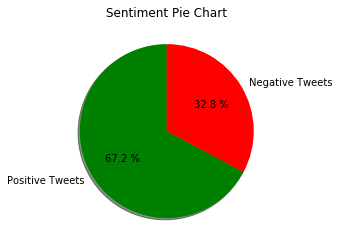

In [41]:
plt.pie([Positive_Tweets,Negative_Tweets ],
        labels=['Positive Tweets','Negative Tweets'],
        colors=['g','r'],
        startangle=90,
        shadow= True,
        autopct='%1.1f %%')
plt.title('Sentiment Pie Chart')
plt.savefig(' sentiment')